In [ ]:
!pip install yfinance

     |████████████████████████████████| 63 kB 735 kB/s 
     |████████████████████████████████| 6.4 MB 3.0 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import yfinance as yf
import math
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates 

# retrieve data from yahoo finance (Note: yfinance is not an official Yahoo API)
df = yf.download('AAPL','2010-01-01','2022-03-22')
# here i'm taking apple as an example

[*********************100%***********************]  1 of 1 completed


Exploring the data (Optional)

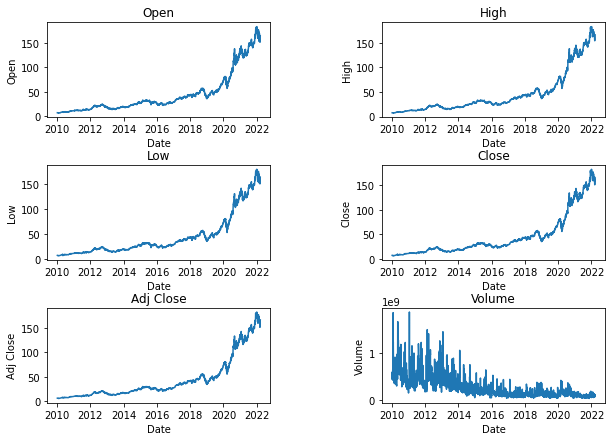

In [ ]:
# I copied this part from a github repo and added some coments

df_plot = df.copy()

list_length = df_plot.shape[1] # number of features in dataframe
ncols = 2
nrows = int(round(list_length / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(10, 7))
fig.subplots_adjust(hspace=0.5, wspace=0.5) # make sure plots don't overlap
for i in range(0, list_length):
        ax = plt.subplot(nrows,ncols,i+1) # create a set of plots
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax) # this line plots the graphs
        ax.set_title(df_plot.columns[i]) # give titles to graphs
        ax.xaxis.set_major_locator(mdates.AutoDateLocator()) # label x axis of graphs
plt.show()

Prepare the dataset for fitting models

In [ ]:
# save a copy of dates before converting to numerical values
train_df = df.sort_values(by=['Date']).copy()
date_index = train_df.index

# We reset the index, so we can convert the date-index to a number-index
train_df = train_df.reset_index(drop=True).copy()

,Open,High,Low,Close,Adj Close,Volume
0,7.622500,7.660714,7.585000,7.643214,6.544687,493729600
1,7.664286,7.699643,7.616071,7.656429,6.556003,601904800
2,7.656429,7.686786,7.526786,7.534643,6.451721,552160000
3,7.562500,7.571429,7.466071,7.520714,6.439792,477131200
4,7.510714,7.571429,7.466429,7.570714,6.482606,447610800


In [ ]:
Feature = ['High', 'Low', 'Open', 'Close', 'Volume']

# drop the unwanted features in a new data set
data = pd.DataFrame(train_df)
data_filtered = data[Feature]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
# add a column in the dataset for prediction
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

Scale the data for better performance

In [ ]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
# -1 here indicates that numpy will calculate the number of columns automatically
np_data = np.reshape(np_data_unscaled, (nrows, -1))

from sklearn.preprocessing import MinMaxScaler 
# Transform the data by scaling each feature to a range between 0 and 1
# by default it's 0 to 1, but if you want sth else, pass feature(0,x) as arg to
# MinMaxScaler()
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler for scaling predictions
# we cannot use the original scaler above because the number of inputs that the 
# scaler above takes differs from the scaler we need for prediction
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)



In [ ]:
# timeframe for single prediction
sequence_length = 50

# Prediction Index
index_Close = data.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# LSTM needs data with the format of [samples, time steps, features]
# so create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)


Create the Model

In [ ]:
# the sequential API of keras allows you to create a deep learning model by 
# adding layers to it
model = Sequential()

# units is the number of neurons in the layer
# very naive model
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# fit it with data we compiled before
history = model.fit(x_train, y_train, 
                    batch_size=32, 
                    epochs=10,
                    validation_data=(x_test, y_test)
                   )

Epoch 1/10
76/76 [==============================] - 10s 68ms/step - loss: 0.0017 - val_loss: 0.0093
Epoch 2/10
76/76 [==============================] - 4s 55ms/step - loss: 6.4654e-05 - val_loss: 0.0017
Epoch 3/10
76/76 [==============================] - 4s 56ms/step - loss: 5.4593e-05 - val_loss: 0.0030
Epoch 4/10
76/76 [==============================] - 4s 55ms/step - loss: 4.9294e-05 - val_loss: 0.0033
Epoch 5/10
76/76 [==============================] - 5s 63ms/step - loss: 4.4582e-05 - val_loss: 0.0039
Epoch 6/10
76/76 [==============================] - 4s 55ms/step - loss: 4.8972e-05 - val_loss: 0.0039
Epoch 7/10
76/76 [==============================] - 4s 55ms/step - loss: 4.1172e-05 - val_loss: 0.0051
Epoch 8/10
76/76 [==============================] - 5s 62ms/step - loss: 3.8166e-05 - val_loss: 0.0024
Epoch 9/10
76/76 [==============================] - 4s 54ms/step - loss: 3.7723e-05 - val_loss: 0.0037
Epoch 10/10
76/76 [==============================] - 4s 55ms/step - loss: 4.

Visualize the model's performance

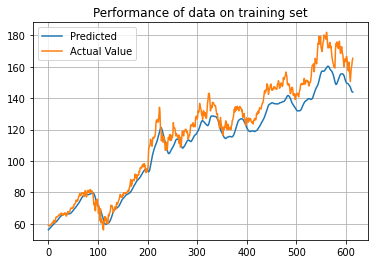

In [ ]:
# predict with the model we trained
y_pred_scaled = model.predict(x_test)
# transform prediction back to the original scale
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
# transform y_test back to the original scale
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

plt.plot(y_pred)
plt.plot(y_test_unscaled)
plt.title('Performance of model')
plt.grid()
plt.legend(['Predicted','Actual Value'])


Future steps include testing it on real-time data sets and more.